# Fitness Model Explainability

In [16]:
import pickle
import numpy as np
import tensorflow as tf
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt 
import re 
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

In [17]:
# Load the pre-trained neural network model
DRAG_MODEL = tf.keras.models.load_model('../best_model15.h5')
DRAG_MODEL.summary()

Model: "sequential_229"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1239 (Dense)          (None, 512)               17408     
                                                                 
 dense_1240 (Dense)          (None, 256)               131328    
                                                                 
 dense_1241 (Dense)          (None, 64)                16448     
                                                                 
 dense_1242 (Dense)          (None, 8)                 520       
                                                                 
 dense_1243 (Dense)          (None, 3)                 27        
                                                                 
Total params: 165,731
Trainable params: 165,731
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Load the scaler used during training
with open("../best_scaler15.obj", "rb") as f:
    MIN_MAX_SCALER = pickle.load(f)

In [19]:
# Constants for feature values
REYNOLDS_NUMBER = 100000
MACH_NUMBER = 0.1
ATTACK_ON_ANGLE = -10

# Constants for y-coordinate values
yCoorUpper = [2.07692721e-02, 3.93104182e-02, 5.46992442e-02,
              6.60399430e-02, 7.26857201e-02, 7.44701301e-02, 7.17682176e-02,
              6.53878200e-02, 5.63418071e-02, 4.57425800e-02, 3.45854691e-02,
              2.37791669e-02, 1.41758894e-02, 6.57918271e-03, 1.68970028e-03]

yCoorLower = [-2.07692721e-02, -3.93104182e-02, -5.46992442e-02, -6.60399430e-02,
               -7.26857201e-02, -7.44701301e-02, -7.17682176e-02, -6.53878100e-02,
               -5.63418071e-02, -4.57425800e-02, -3.45854691e-02, -2.37791669e-02,
               -1.41758894e-02, -6.57918271e-03, -1.68970028e-03]

# Combine features into a single input array
features = [yCoorUpper + yCoorLower + [REYNOLDS_NUMBER, MACH_NUMBER, ATTACK_ON_ANGLE]]

# Scale features using the saved scaler
features_scaled = MIN_MAX_SCALER.transform(features)

# Convert the features to a TensorFlow tensor
features_tensor = tf.convert_to_tensor(features_scaled, dtype=tf.float32)

print(features_tensor)

tf.Tensor(
[[0.09695625 0.1765472  0.23757952 0.27921125 0.31025884 0.3352225
  0.35734844 0.37673324 0.37579215 0.35028437 0.31835955 0.2753442
  0.2172864  0.18032818 0.12347302 0.43554625 0.3320697  0.35996744
  0.35892373 0.35068452 0.35838702 0.37427148 0.3881213  0.37185037
  0.33728394 0.29230866 0.2606982  0.24174689 0.23097213 0.22822781
  0.         0.         0.        ]], shape=(1, 33), dtype=float32)


In [20]:
# Make predictions using the neural network model
predictions = DRAG_MODEL.predict(features_tensor)
print(predictions)

1/1 [==============================] - 0s 76ms/step
[[-1.0672921   0.03560191  0.00916074]]


In [21]:
# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=np.array(features_scaled),
  #  feature_names=["feature_" + str(i) for i in range(len(features_scaled[0]))],  
    feature_names = [
        "yCoorUpper" + str(i) if i < 15 else
        "yCoorLower" + str(i) if 15 <= i <= 29 else
        "REYNOLDS_NUMBER" + str(i) if i == 30 else
        "MACH_NUMBER" + str(i) if i == 31 else
        "ATTACK_ON_ANGLE" + str(i) if i == 33 else
        "feature_" + str(i)
        for i in range(len(features_scaled[0]))],
    mode="regression",
)

# Define the predict function for the explainer
def predict_function(X):
    # Flatten the 3D array to 2D
    X = X.reshape((X.shape[0], -1))
    # Preprocess input data before making predictions
    X_scaled = MIN_MAX_SCALER.transform(X)
    # Convert to tensor
    X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
    # Make predictions using the neural network
    predictions = DRAG_MODEL.predict(X_tensor)
    return predictions

In [22]:
def remove_numbers_and_underscores(text):
    pattern = re.compile(r'[\d_]+')
    result = re.sub(pattern, '', text)
    return result

In [23]:
# Choose an instance for explanation
instance_to_explain = features_scaled[0]

# Get an explanation for the prediction
explanation = explainer.explain_instance(
    instance_to_explain,
    predict_function,
    num_features=len(features_scaled[0]),
)

# Display the explanation
#explanation.show_in_notebook()

157/157 [==============================] - 0s 2ms/step


In [24]:
top_features = explanation.as_list()

In [25]:
def get_values(top_features):
    pattern1 = r'\(\'([^\']+)\s*<=\s*[0-9.]+\','
    pattern2 = r'\d+\.\d+'
    vs= []
    try:
        for v in top_features:
            text = str(v)
            vs.append(
                {
                    re.findall(pattern1, text)[0]: float(re.findall(pattern2, text)[0])
                }
            )
        return vs
    except Exception as e:
        print(e)
        
f = get_values(top_features)
sorted_data = sorted(f, key=lambda x: list(x.values())[0], reverse=True)

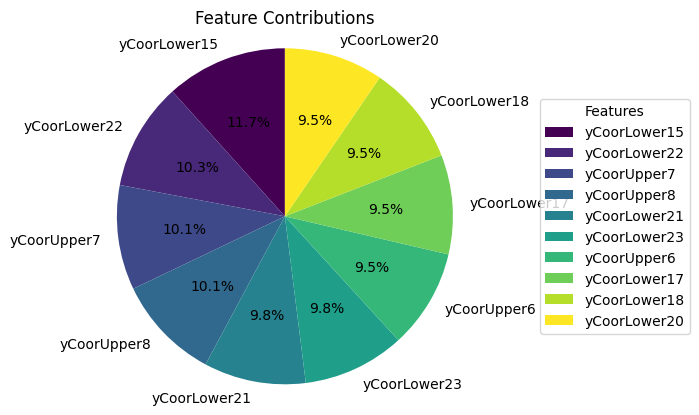

In [26]:
top_n = 10
top_n_data = sorted_data[:top_n]

# Extract feature names and corresponding values
feature_names = [list(d.keys())[0].strip() for d in top_n_data]
values = [list(d.values())[0] for d in top_n_data]

colors = plt.cm.viridis(np.linspace(0, 1, top_n))
plt.pie(values, labels=feature_names, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('Feature Contributions')
plt.legend(feature_names, title="Features", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

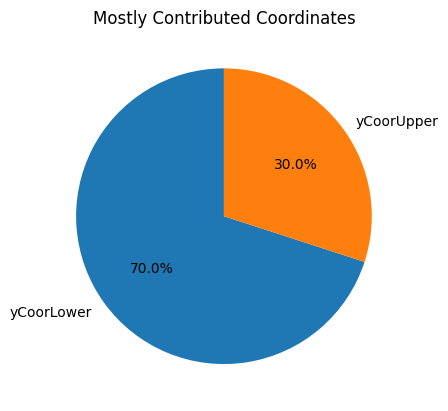

In [27]:
feature_names = [remove_numbers_and_underscores(name) for name in feature_names]
counts = Counter(feature_names)
labels = counts.keys()
sizes = counts.values()

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Mostly Contributed Coordinates')
plt.show()